In [1]:
import numpy as np
import os
import pandas as pd
import h5py
import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from toolbox.utils import set_random_seed
from toolbox.plt_utils import density_scatter

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# for TF To find gpu
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CONDA_PREFIX']}/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

In [4]:
# set random seed for reproducibility
set_random_seed(seed=42)

TensorFlow not installed, skipping tf seeding.


/home/valehvpa/miniconda3/envs/hist6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


# Input control as shortcut?

First imma check the hv2

In [3]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/train/instance-20251222_185734/pt_artifacts/best_model.ckpt"
from histobpnet.model.histobpnet_wrapper_v2 import HistoBPNetWrapperV2
model_wrapper = HistoBPNetWrapperV2.load_from_checkpoint(p, map_location='cpu')

/home/valehvpa/miniconda3/envs/hist6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model_wrapper.model.bpnet.linear.bias

Parameter containing:
tensor([-0.1163], requires_grad=True)

In [15]:
model_wrapper.model.bpnet.linear.weight.shape, model_wrapper.model.bpnet.linear.weight

(torch.Size([1, 513]),
 Parameter containing:
 tensor([[ 3.9426e-02, -5.2616e-02, -1.4256e-01,  5.5758e-02, -1.0856e-01,
          -1.2269e-01, -5.2648e-02,  9.9493e-03, -4.8497e-03, -3.1535e-02,
          -3.1281e-03, -1.1009e-01, -7.7378e-02, -8.7441e-03, -1.7607e-01,
           3.9682e-02, -2.2097e-02, -1.1056e-01, -1.4910e-01, -4.4468e-02,
          -1.6859e-01, -2.8262e-02, -1.0034e-01, -3.2615e-02, -1.3551e-01,
          -4.7353e-02,  6.3039e-03,  2.3324e-01, -1.9859e-01,  3.3572e-02,
          -4.8405e-02, -1.0470e-01, -6.7771e-02,  9.8945e-04, -1.6769e-01,
          -3.2997e-02, -2.0457e-03, -2.7316e-02,  1.2475e-02,  7.9053e-02,
          -1.1901e-01, -6.2540e-02, -7.8675e-02, -6.4694e-02, -1.0318e-01,
          -5.4311e-02, -4.0296e-02, -7.4535e-02,  3.3050e-02, -1.4597e-02,
          -1.3087e-01, -4.2477e-02, -1.3193e-01, -5.8588e-03, -8.1968e-03,
          -1.4694e-01,  1.0759e-01, -3.7910e-02, -1.2374e-01, -6.4087e-02,
           8.9083e-02,  8.4220e-02, -5.3440e-03, -3.17

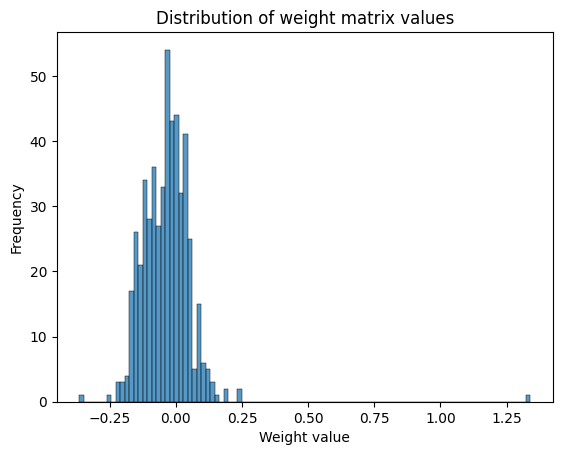

In [ ]:
# plot distibution of the values in the weight matrix
sns.histplot(model_wrapper.model.bpnet.linear.weight.flatten().detach().numpy(), bins=100)
plt.title("Distribution of weight matrix values")
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.show()

In [21]:
# to numpy
weight_matrix = model_wrapper.model.bpnet.linear.weight.detach().numpy()
weight_matrix.squeeze().shape
# index of the max value in weight_matrix
# weight_matrix: np.ndarray
flat_idx = np.argmax(weight_matrix)
idx = np.unravel_index(flat_idx, weight_matrix.shape)

print(idx)        # tuple of indices
print(flat_idx)  # flat index
print(weight_matrix.shape)

(0, 512)
512
(1, 513)


In [ ]:
w = weight_matrix.flatten()

w_max = w.max()
w_p999 = np.quantile(w, 0.999)
w_p99 = np.quantile(w, 0.99)

print("max:", w_max.item())
print("99.9%:", w_p999.item())
print("99%:", w_p99.item())
print("max / p99.9:", (w_max / w_p999).item())

max: 1.3397750854492188
99.9%: 0.7732288832664485
99%: 0.15797747671604148
max / p99.9: 1.7327018098307938


How to interpret:

- max ≈ 99.9th percentile

Smooth heavy tail

No single dominating parameter

Usually benign

- max ≫ 99.9th percentile (e.g. 2×–10× larger)

One or a few parameters dominate

Often corresponds to:

a specific feature/motif being decisive

scale invariance downstream (BN, log link, exp)

occasional training artifacts

- max ≫≫ rest + unstable training

Possible pathology (rare unless no normalization or bad LR)

This matches what I expected: one feature (the last one -- namly log scaled input control) is dominating the linear layer output.  

Now I'll do it for the ither version of hv2: hv2-finetune-encfix-csf1.0-closest-olneg1k|instance-20251221_173506

In [23]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/train/instance-20251221_173506/pt_artifacts/best_model.ckpt"
from histobpnet.model.histobpnet_wrapper_v2 import HistoBPNetWrapperV2
model_wrapper2 = HistoBPNetWrapperV2.load_from_checkpoint(p, map_location='cpu')

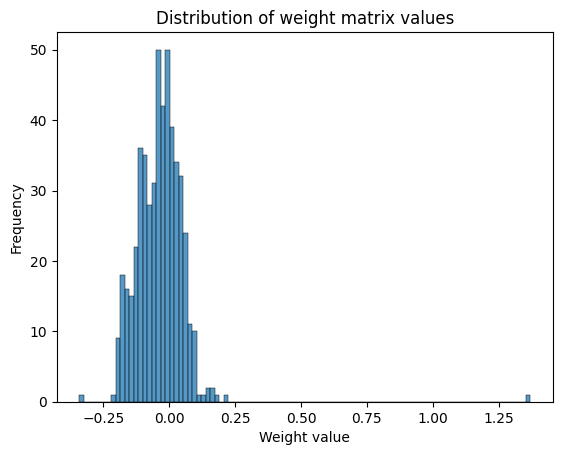

In [25]:
# plot distibution of the values in the weight matrix
sns.histplot(model_wrapper2.model.bpnet.linear.weight.flatten().detach().numpy(), bins=100)
plt.title("Distribution of weight matrix values")
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.show()

In [26]:
# to numpy
weight_matrix = model_wrapper2.model.bpnet.linear.weight.detach().numpy()
weight_matrix.squeeze().shape
# index of the max value in weight_matrix
# weight_matrix: np.ndarray
flat_idx = np.argmax(weight_matrix)
idx = np.unravel_index(flat_idx, weight_matrix.shape)

print(idx)        # tuple of indices
print(flat_idx)  # flat index
print(weight_matrix.shape)

w = weight_matrix.flatten()
w_max = w.max()
w_p999 = np.quantile(w, 0.999)
w_p99 = np.quantile(w, 0.99)

print("max:", w_max.item())
print("99.9%:", w_p999.item())
print("99%:", w_p99.item())
print("max / p99.9:", (w_max / w_p999).item())

(0, 512)
512
(1, 513)
max: 1.3706960678100586
99.9%: 0.7746892943382258
99%: 0.15401581108570095
max / p99.9: 1.7693494383202604


Same thing..

## What about v3?

**** 20251221_171312: 200bp


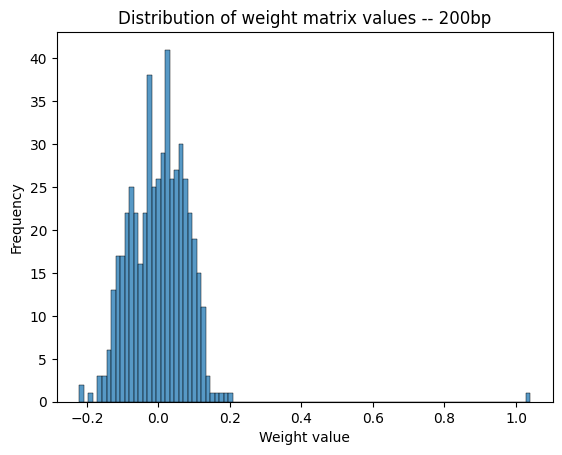

(0, 512)
512
(1, 513)
max: 1.0402921438217163
99.9%: 0.6114995561838146
99%: 0.15021903634071343
max / p99.9: 1.7012148795558704
**** 20251221_171134: 500bp


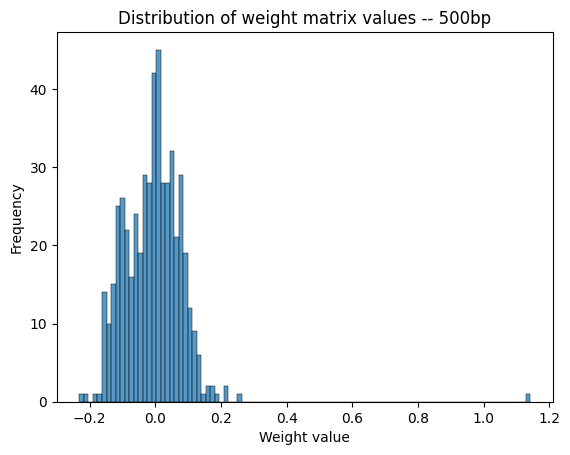

(0, 512)
512
(1, 513)
max: 1.1421695947647095
99.9%: 0.6885606768131252
99%: 0.17773955106735229
max / p99.9: 1.65877842465682
**** 20251221_170812: 5000bp


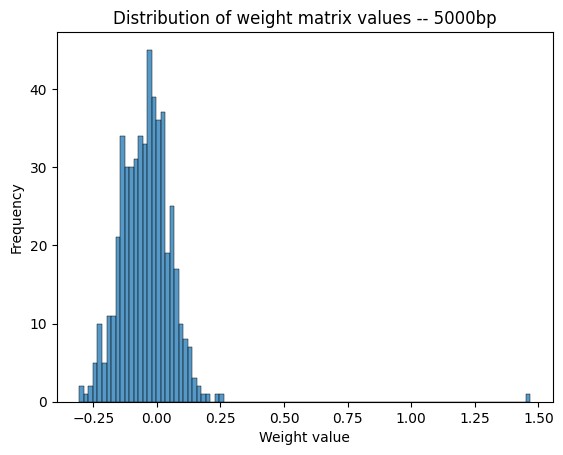

(0, 512)
512
(1, 513)
max: 1.468300700187683
99.9%: 0.8443211171627039
99%: 0.17038211762905117
max / p99.9: 1.7390311225684245
**** 20251221_170733: 4000bp


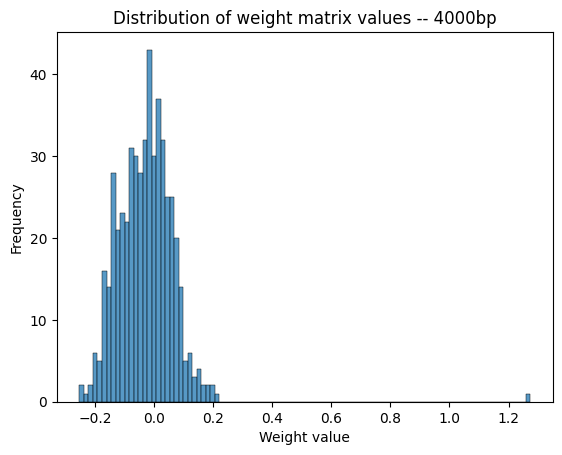

(0, 512)
512
(1, 513)
max: 1.2739906311035156
99.9%: 0.7335827941894526
99%: 0.18188119590282434
max / p99.9: 1.7366691819853386
**** 20251221_170631: 3000bp


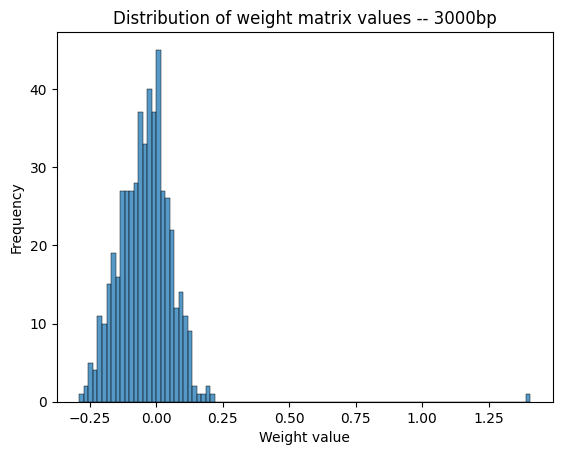

(0, 512)
512
(1, 513)
max: 1.4064247608184814
99.9%: 0.7948758404254908
99%: 0.16356149911880483
max / p99.9: 1.7693640808929774
**** 20251221_170509: 2000bp


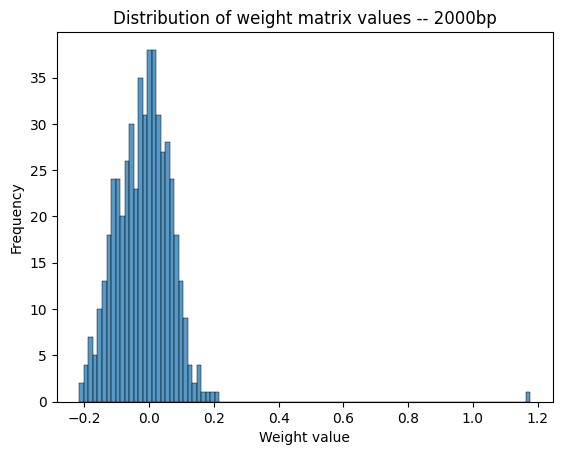

(0, 512)
512
(1, 513)
max: 1.1774864196777344
99.9%: 0.6842832031249996
99%: 0.15976432144641875
max / p99.9: 1.7207589113693913
**** 20251221_161307: 1000bp


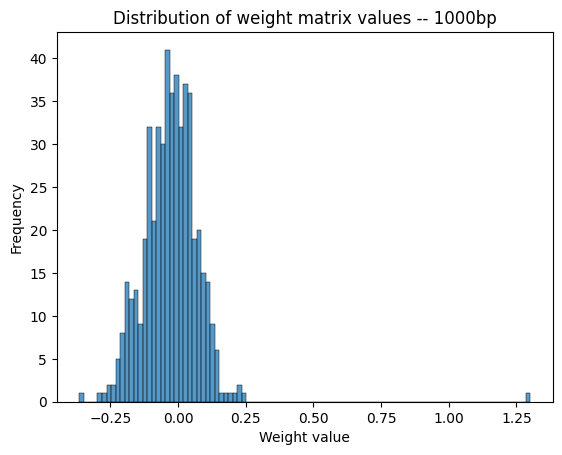

(0, 512)
512
(1, 513)
max: 1.3014248609542847
99.9%: 0.7569532423019404
99%: 0.1982442808151244
max / p99.9: 1.7192935946698285


In [27]:
d = {
    "20251221_171312": 200,
    "20251221_171134": 500,
    "20251221_170812": 5000,
    "20251221_170733": 4000,
    "20251221_170631": 3000,
    "20251221_170509": 2000,
    "20251221_161307": 1000,
}

for instid, hgp_width in d.items():
    print(f"**** {instid}: {hgp_width}bp")
    bp = f"/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v3/train/instance-{instid}"
    p = f"{bp}/pt_artifacts/best_model.ckpt"
    from histobpnet.model.histobpnet_wrapper_v3 import HistoBPNetWrapperV3
    model_wrapper = HistoBPNetWrapperV3.load_from_checkpoint(p, map_location='cpu')

    # plot distibution of the values in the weight matrix
    sns.histplot(model_wrapper.model.bpnet.linear.weight.flatten().detach().numpy(), bins=100)
    plt.title(f"Distribution of weight matrix values -- {hgp_width}bp")
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.show()

    # to numpy
    weight_matrix = model_wrapper.model.bpnet.linear.weight.detach().numpy()
    weight_matrix.squeeze().shape
    # index of the max value in weight_matrix
    # weight_matrix: np.ndarray
    flat_idx = np.argmax(weight_matrix)
    idx = np.unravel_index(flat_idx, weight_matrix.shape)

    print(idx)        # tuple of indices
    print(flat_idx)  # flat index
    print(weight_matrix.shape)

    w = weight_matrix.flatten()
    w_max = w.max()
    w_p999 = np.quantile(w, 0.999)
    w_p99 = np.quantile(w, 0.99)

    print("max:", w_max.item())
    print("99.9%:", w_p999.item())
    print("99%:", w_p99.item())
    print("max / p99.9:", (w_max / w_p999).item())

Ok it s the same for all of them. I'm pretty sure the reason for the perf getting better as we increase hgp_width (see the fig below) is not that the model is actually. learning syntax from the sequence that explains the observed signal, but rather that as we increase hgp_width, the correlation between the log scaled input and the target (log chip) increases, and since the model is relying heavily on that feature (ie log scaled input), the performance improves. I'm not going to verify this though.

<img src="/home/valehvpa/projects/scCisTrans/histobpnet/experiments/valeh/notebooks/in_figs/hv3_perf.png" width="500">

I had another thought: if the scaling facotr is learned from the training set (which heavily prioritizes peaks, due to the 10:1 negative sampling ratio), then we should in theory see a pretty "bad" performance on non-peaks (both in training and val and even more so in test set where the sampling ratio is 1:1 iirc), since presumably the scaling factor learned from peaks would not generalize well to non-peaks. Though I think that should still yield a good pearson (since there should still be correlation, just not a linear relationship... think about it...), but not a good mse. Anyway, I think the next most helpful step is to actually stop feeding control and see what the model can _actually_ learn from sequence alone!

## what of bpnet?

How come this isnt the case with bpnet though? :hmm:

In [28]:
!wget https://mitra.stanford.edu/kundaje/shouvikm/BPNet/models/REH_ETV6-RUNX1_rep1/fold_0/model_split000/saved_model.pb

--2026-01-05 22:38:48--  https://mitra.stanford.edu/kundaje/shouvikm/BPNet/models/REH_ETV6-RUNX1_rep1/fold_0/model_split000/saved_model.pb
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 749779 (732K)
Saving to: ‘saved_model.pb’

saved_model.pb      100%[===================>] 732.21K  1.04MB/s    in 0.7s    

2026-01-05 22:38:50 (1.04 MB/s) - ‘saved_model.pb’ saved [749779/749779]



fwiw my conclusion here after some chatgpt to understand the TF code was that the bpnet TF version uses two linear layers, not one, and per chatgpt that coudl affect the extent to which the model is able to cheat. So I'm going to try a version where we use two linear layers instead of one. chat: https://chatgpt.com/c/695cad6d-460c-8328-b400-fc8e0bdc44fd

## new model (separate linear for control)

In [6]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/train/instance-20260106_172930/pt_artifacts/best_model.ckpt"
from histobpnet.model.histobpnet_wrapper_v2 import HistoBPNetWrapperV2
model_wrapper = HistoBPNetWrapperV2.load_from_checkpoint(p, map_location='cpu')
model_wrapper.model.bpnet.linear.weight.shape

torch.Size([1, 512])

In [8]:
model_wrapper.model.bpnet.linear_w_ctrl.weight.shape

torch.Size([1, 2])

In [9]:
model_wrapper.model.bpnet.linear_w_ctrl.weight

Parameter containing:
tensor([[0.1956, 1.3888]], requires_grad=True)

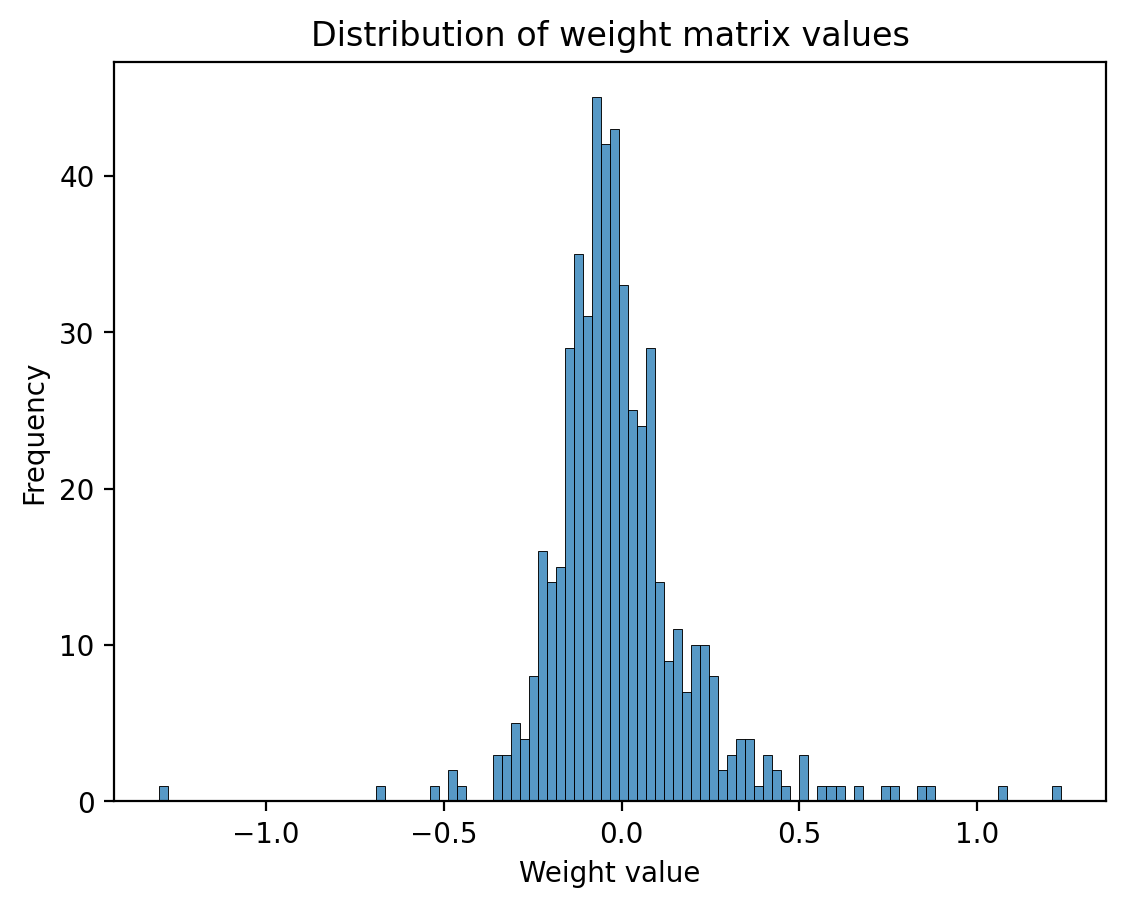

(0, 456)
456
(1, 512)
max: 1.2353370189666748
99.9%: 1.1456851923465687
99%: 0.7395934140682209
max / p99.9: 1.0782517110450587


In [13]:
# plot distibution of the values in the weight matrix
sns.histplot(model_wrapper.model.bpnet.linear.weight.flatten().detach().numpy(), bins=100)
plt.title(f"Distribution of weight matrix values")
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.show()

# to numpy
weight_matrix = model_wrapper.model.bpnet.linear.weight.detach().numpy()
weight_matrix.squeeze().shape
# index of the max value in weight_matrix
# weight_matrix: np.ndarray
flat_idx = np.argmax(weight_matrix)
idx = np.unravel_index(flat_idx, weight_matrix.shape)

print(idx)        # tuple of indices
print(flat_idx)  # flat index
print(weight_matrix.shape)

w = weight_matrix.flatten()
w_max = w.max()
w_p999 = np.quantile(w, 0.999)
w_p99 = np.quantile(w, 0.99)

print("max:", w_max.item())
print("99.9%:", w_p999.item())
print("99%:", w_p99.item())
print("max / p99.9:", (w_max / w_p999).item())

I read this from shouvik s trained bpnet (TF) model

In [10]:
# GPUCA6E :: ~/projects/toolbox ‹valeh/misc› » ca hist_explore4
# (hist_explore4) GPUCA6E :: ~/projects/toolbox ‹valeh/misc› » ipython 
# Python 3.10.13 (main, Sep 11 2023, 13:21:10) [GCC 11.2.0]
# Type 'copyright', 'credits' or 'license' for more information
# IPython 8.37.0 -- An enhanced Interactive Python. Type '?' for help.
# Ctrl click to launch VS Code Native REPL

# In [1]: import tensorflow as tf

# In [2]: p = "/home/valehvpa/projects/scCisTrans/histobpnet/experiments/valeh/notebooks/data/bpnet_test_temp/one"

# In [3]: o = tf.saved_model.load(p)
# 2026-01-06 17:59:54.977395: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
# 2026-01-06 17:59:54.977433: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
# 2026-01-06 17:59:54.977758: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
# To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

# In [4]: o
# Out[4]: <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fcfe829b490>

# In [5]: for v in o.variables:
#    ...:     print(v.name, v.shape)
#    ...: 
# main_conv_0/kernel:0 (21, 4, 64)
# main_conv_0/bias:0 (64,)
# main_dil_conv_1/kernel:0 (3, 64, 64)
# main_dil_conv_1/bias:0 (64,)
# main_dil_conv_2/kernel:0 (3, 64, 64)
# main_dil_conv_2/bias:0 (64,)
# main_dil_conv_3/kernel:0 (3, 64, 64)
# main_dil_conv_3/bias:0 (64,)
# main_dil_conv_4/kernel:0 (3, 64, 64)
# main_dil_conv_4/bias:0 (64,)
# main_dil_conv_5/kernel:0 (3, 64, 64)
# main_dil_conv_5/bias:0 (64,)
# main_dil_conv_6/kernel:0 (3, 64, 64)
# main_dil_conv_6/bias:0 (64,)
# main_dil_conv_7/kernel:0 (3, 64, 64)
# main_dil_conv_7/bias:0 (64,)
# main_dil_conv_8/kernel:0 (3, 64, 64)
# main_dil_conv_8/bias:0 (64,)
# main_profile_head/kernel:0 (75, 64, 2)
# main_profile_head/bias:0 (2,)
# main_counts_head/kernel:0 (64, 1)
# main_counts_head/bias:0 (1,)
# profile_predictions/kernel:0 (1, 4, 2)
# profile_predictions/bias:0 (2,)
# logcounts_predictions/kernel:0 (2, 1)
# logcounts_predictions/bias:0 (1,)
# total:0 ()
# count:0 ()

# In [6]: # find the kernel
#    ...: W = next(v for v in o.variables if v.name == "logcounts_predictions/kernel:0").numpy()
#    ...: # shape: (2, 1)
#    ...: 
#    ...: # flatten for convenience
#    ...: w = W[:, 0]

# In [7]: w
# Out[7]: array([-0.12239306,  0.4503824 ], dtype=float32)

## Abaltions

chat w/ chatgpt: https://chatgpt.com/c/695cad6d-460c-8328-b400-fc8e0bdc44fd

Also, I did the ablataion where I passed all-zeros seq (same ctl and cts), and it barely affected perf (I ran a prediction run, so on the test set): https://wandb.ai/valehamiri/histobpnet/runs/d6m10fzd?nw=nwuservalehamiri.

I then did another ablation where I passed all-zeros for ctl (no changes to seq and cts), and it tanked perf. Barring any other confounding factors I'm missing, I think this confirms that the model is relying almost exclusively on ctl for prediction. https://wandb.ai/valehamiri/histobpnet/runs/c6b1fl34?nw=nwuservalehamiri

fwiw i still have these questions:
- why doesnt this happen with bpnet??
- (why) doenst ziwei see it? or does she? https://mitra.stanford.edu/kundaje/oak/ziwei75/histone_mark/exp/K562_h3k27ac/